In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import numpy as np
import pandas as pd
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding, FCEmbedding
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi import analysis

from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import matplotlib.pyplot as plt

2025-03-18 11:44:16.046868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742294656.059390    9055 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742294656.063084    9055 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742294656.072602    9055 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742294656.072619    9055 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742294656.072620    9055 computation_placer.cc:177] computation placer alr

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("GPU Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA available: True
GPU Device: NVIDIA GeForce RTX 2080 Super with Max-Q Design


In [3]:
ts, dt = (30.0, 0.1)
def simulator(theta):
    m, k, b = theta
    steps = int(ts/dt)
    x, v = 0, 5  # Initial conditions
    force = np.cos(np.arange(steps) * dt * 10)
    trajectory = []

    for f in force:
        x_new = x + dt * v
        v_new = v + dt * (-k * x / m - b * v / m + f / m)
        x, v = x_new, v_new
        trajectory.append([x, v])

    return torch.tensor(trajectory)

In [4]:
true_parameter = torch.tensor([10, 5.0, 2.0])
x_observed = simulator(true_parameter)

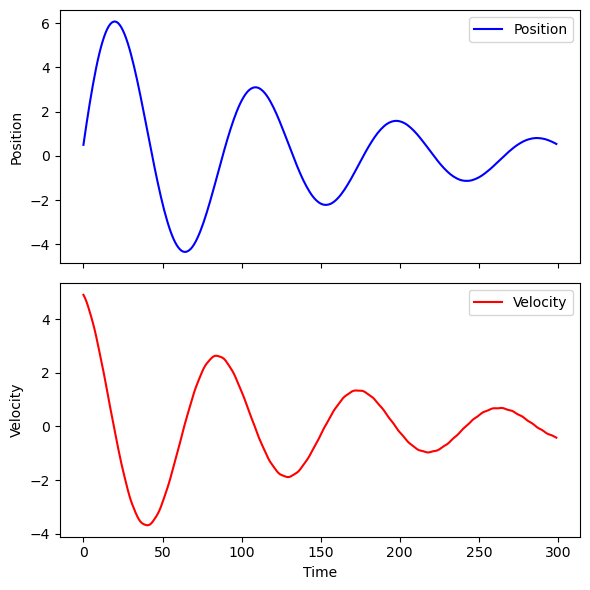

In [5]:
t = torch.arange(len(x_observed))

fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# Plot first column
axes[0].plot(t, x_observed[:, 0], label="Position", color="b")
axes[0].set_ylabel("Position")
axes[0].legend()

# Plot second column
axes[1].plot(t, x_observed[:, 1], label="Velocity", color="r")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [6]:
prior = BoxUniform(low=torch.tensor([5.0, 2.0, 0.5]),
                             high=torch.tensor([15.0, 8.0, 5.0]))

# make a SBI-wrapper on the simulator object for compatibility
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator_wrapper = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [7]:
num_simulations = 10000
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
class LSTMEmbeddingNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=2, output_dim=16, batch_first=True, dropout=0.1):
        super(LSTMEmbeddingNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=batch_first, 
                            dropout=dropout, bidirectional=True)
        self.norm = nn.LayerNorm(hidden_dim * 2)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        # LSTM output shape: (batch, seq_len, hidden_dim * 2) for bidirectional
        output, (h_n, c_n) = self.lstm(x)

        # Combine hidden states from both directions (last layer from both forward and backward)
        h_forward = h_n[-2]  # Last layer's forward hidden state
        h_backward = h_n[-1]  # Last layer's backward hidden state
        summary = torch.cat((h_forward, h_backward), dim=-1)  # Shape: (batch, hidden_dim * 2)

        # Normalize and project using MLP
        summary = self.norm(summary)
        summary = self.mlp(summary)  # Shape: (batch, output_dim)

        return summary

In [9]:
hidden_dim=128
num_layers=3
embedding_net = LSTMEmbeddingNet(hidden_dim=hidden_dim, num_layers=num_layers)

neural_posterior = posterior_nn(
    model='nsf', 
    embedding_net=embedding_net,
    num_transforms=20,
    use_batch_norm=True,
    )

optimizer = torch.optim.Adam(embedding_net.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=1.2)

inferer = NPE(prior=prior, density_estimator=neural_posterior)

In [10]:
# x_flattened = x.view(x.size(0), -1)

In [ ]:
inferer.append_simulations(theta, x).train()

 Training neural network. Epochs trained: 7

In [11]:
posterior = inferer.build_posterior()

In [12]:
samples = posterior.sample((1000,), x=x_observed)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

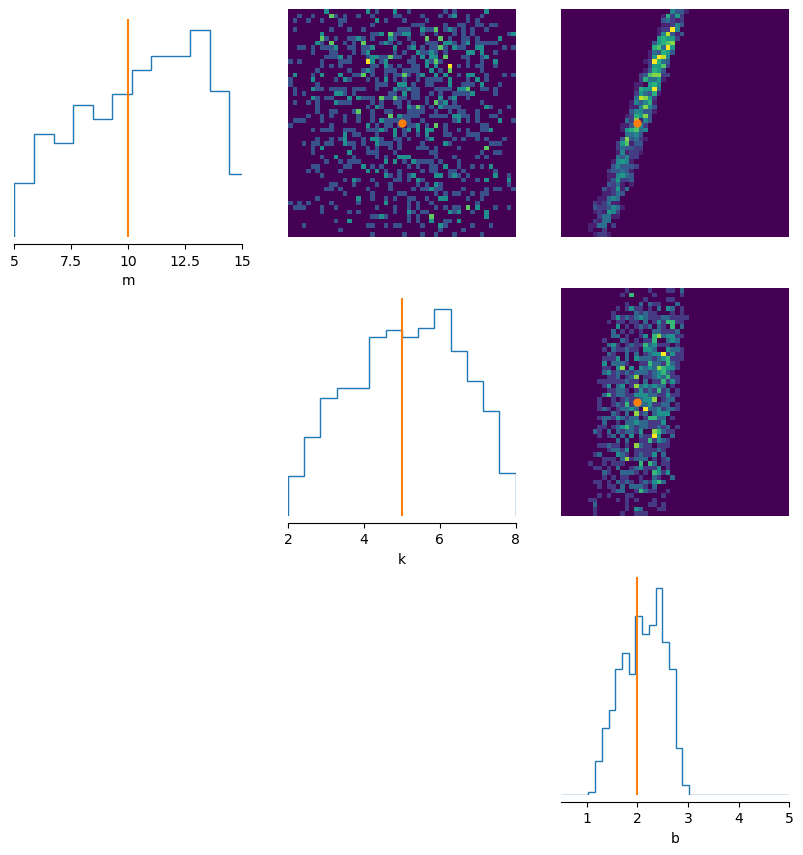

In [13]:
fig, ax = analysis.pairplot(
    samples,
    points=true_parameter.unsqueeze(0),
    labels=["m", "k", "b"],
    limits=[[5, 15], [2.0, 8.0], [0.5, 5.0]]
)